In [1]:
import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d.axes3d as p3
# import matplotlib.animation as animation
import pandas as pd

%matplotlib notebook 
%matplotlib notebook 

plt.rcParams.update({'font.size': 14})

# dataPath = ".\Pilot20220325LeakOil"
dataPath = ".\CurrentData"

In [2]:
'''
General function
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (12,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax

# The default decoding format is one float number
def decodeTrackData(dataFormat, dataStr, numFormat = "\d+\.\d+", numNum = 1):
    findResult = re.findall(dataFormat, aLine)
    
    findData = []
    
    if findResult:
        findNums = re.findall(numFormat, findResult[0])
        if(len(findNums) != numNum):
            print("Incorrectly find %d %s given %d in command" % (len(findNums), numFormat, numNum))
            return findData
        else:
            for num in findNums:
                try:
                    num = float(num)
                except:
                    pass               
                findData.append(num)

    else: # Padding None if no number is found
        findData = [None] * numNum
        
    return findData

def decodeTaskSummary(taskFormat, completeStatusFormat, completeTimeFormat, dataStr):
    findData = []
    
    taskSummaries = re.findall(taskFormat+completeStatusFormat+completeTimeFormat, dataStr)
    
    for taskSummary in taskSummaries:
        res = re.findall(taskFormat+"|"+completeStatusFormat+"|"+completeTimeFormat, taskSummary)
        try:
            res[2] = float(res[2])
        except:
            pass   
        findData.append(res)
    
    return findData
    

In [4]:
'''
Data format
'''

vrDataInfo = [] # dataStamp, trialNum, voltageLevel, startTime, score
vrDataTrack = {} # time (secs), indexX, indexY, indexZ, thumbX, thumbY, thumbZ, indexDist, thumbDist, object
vrDataSummary = {} # object, taskResult, competeTime (secs)

for root, directories, files in walk(dataPath):
    for fileName in files:
        if(re.search('\.txt', fileName)):
            condi = re.split('_|\.txt', fileName)
            dataStamp = condi[0]
            trialNum = int(re.findall("\d+", condi[-2])[0])

            file1 = open(ospa.join(root, fileName), 'r')
            fileLines = file1.readlines()
            
            dataTrack = [] # time (secs), indexX, indexY, indexZ, thumbX, thumbY, thumbZ, indexDist, thumbDist, object
            subjectId = None
            taskId = None
            voltageLevel = None # voltageLevel, 
            startTime = None # startTime (Universal Time)
            dataSummary = [] # object, taskResult, competeTime (secs)
            score = None # Final score               
            
            for aLine in fileLines:
                if(aLine[0] == 't'):  
                    aTrackFrame = []
                    
                    # time (secs)
                    aTrackFrame.extend(decodeTrackData("t\d+\.\d+", aLine))
                    
                    # (indexX, indexY, indexZ)
                    aTrackFrame.extend(decodeTrackData("le\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
            
                    # (thumbX, thumbY, thumbZ)
                    aTrackFrame.extend(decodeTrackData("re\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
                    
                    # (indexX, indexY, indexZ)
                    aTrackFrame.extend(decodeTrackData("in\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
            
                    # (thumbX, thumbY, thumbZ)
                    aTrackFrame.extend(decodeTrackData("th\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
                    
                    # indexDist
                    aTrackFrame.extend(decodeTrackData("indi\d+\.\d+", aLine))
                    
                    # thumbDist
                    aTrackFrame.extend(decodeTrackData("thdi\d+\.\d+", aLine))
                    
                    # object (Name)
                    aTrackFrame.extend(decodeTrackData("Grape\d+ | Key\d+", aLine, "Grape\d+ | Key\d+"))
             
                    dataTrack.append(aTrackFrame)
                
                elif(aLine[0] == 'v'):
                    voltageLevel = decodeTrackData("voltLevel\d+", aLine, "\d+")[0]
                    
                    startTime = decodeTrackData("starttimestamp\d+", aLine, "\d+")[0]
                    
                    subjectId = decodeTrackData("subjectid\d+", aLine, "\d+")[0]
                    
                    taskId = decodeTrackData("taskid\d+", aLine, "\d+")[0]
                    
                    completeInfo = re.findall("completeinfo.*", aLine)[0]
                    
                    dataSummary = []
                    dataSummary.extend(decodeTaskSummary("Grape\d+", "[a-zA-Z]+", "\d+\.\d+", completeInfo))
                    dataSummary.extend(decodeTaskSummary("A\d+E\d+", "[a-zA-Z]+", "\d+\.\d+", completeInfo))
                    
                    score = decodeTrackData("score\d+", completeInfo, "\d+")[0]
            
            print(dataStamp)
            
            vrDataTrack[dataStamp] = pd.DataFrame(dataTrack, columns = ['Time', 'LeftEyeX', 'LeftEyeY', 'LeftEyeZ', 
                                                                        'RightEyeX', 'RightEyeY', 'RightEyeZ', 
                                                                        'IndexX', 'IndexY', 'IndexZ', 
                                                                        'ThumbX', 'ThumbY', 'ThumbZ', 
                                                                        'IndexDist', 'ThumbDist', 'Object'])
            
            vrDataSummary[dataStamp] = pd.DataFrame(dataSummary, columns = ['Object', 'TaskResult', 'CompeteTime'])
            
            vrDataInfo.append([dataStamp, trialNum, subjectId, taskId, voltageLevel, startTime, score])
            
vrDataInfo = pd.DataFrame(vrDataInfo, columns = ['Label', 'Trial', 'SubjectId', 'TaskId', 'VoltLevel', 
                                                 'StartTime', 'Score'])        
print(vrDataInfo)

Data19-45-38
Data19-50-24
Data19-53-48
Data20-42-35
Data20-57-11
Data21-17-54
Data21-24-25
Data21-29-23
Data21-33-45
Data21-38-08
          Label  Trial  SubjectId TaskId  VoltLevel  StartTime  Score
0  Data19-45-38      0        0.0   None        0.0       66.0    0.0
1  Data19-50-24      0        0.0   None        0.0       65.0    1.0
2  Data19-53-48      0        0.0   None        0.0       13.0    0.0
3  Data20-42-35      0        0.0   None        0.0       26.0    0.0
4  Data20-57-11      0        0.0   None        0.0       19.0    0.0
5  Data21-17-54      0        0.0   None        0.0       14.0    1.0
6  Data21-24-25      0        0.0   None        0.0       18.0    0.0
7  Data21-29-23      0        NaN   None        NaN        NaN    NaN
8  Data21-33-45      0        0.0   None        0.0       63.0    4.0
9  Data21-38-08      0        0.0   None        0.0       14.0    6.0


In [6]:
selectLabel = dataStamp # The most recent data
selectLabel = 'Data21-17-54'

trData = vrDataTrack[selectLabel]
trData.head()

,Time,LeftEyeX,LeftEyeY,LeftEyeZ,RightEyeX,RightEyeY,RightEyeZ,IndexX,IndexY,IndexZ,ThumbX,ThumbY,ThumbZ,IndexDist,ThumbDist,Object
0,15.452,1.76,1.45,1.02,1.78,1.45,1.07,1.4,1.18,1.29,1.41,1.17,1.29,0.0,0.0,None
1,15.457,1.76,1.45,1.02,1.78,1.45,1.07,1.4,1.18,1.30,1.41,1.17,1.29,0.0,0.0,None
2,15.470,1.76,1.45,1.02,1.78,1.45,1.07,1.4,1.18,1.30,1.41,1.18,1.29,0.0,0.0,None
3,15.480,1.76,1.45,1.02,1.78,1.45,1.07,1.4,1.19,1.30,1.41,1.18,1.30,0.0,0.0,None
4,15.491,1.76,1.45,1.02,1.78,1.45,1.07,1.4,1.19,1.30,1.41,1.18,1.30,0.0,0.0,None


<IPython.core.display.Javascript object>


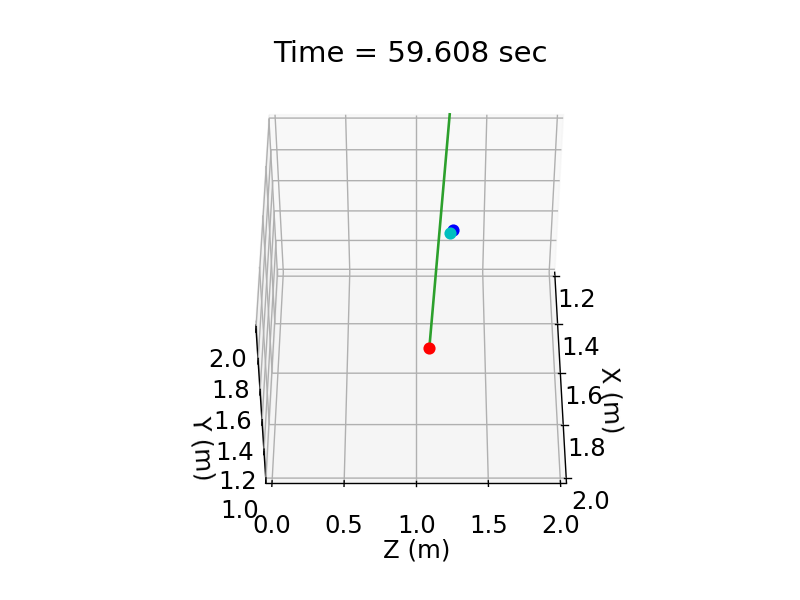

In [7]:
'''
Plot Tracking data
'''
t = trData['Time'].values
t = t - t[0]

eyeCenter = np.array([0.5 * (trData['LeftEyeX'].values + trData['RightEyeX'].values), 
                      0.5 * (trData['LeftEyeY'].values + trData['RightEyeY'].values), 
                      0.5 * (trData['LeftEyeZ'].values + trData['RightEyeZ'].values)]).T

eyeLinkVect = np.array([trData['LeftEyeX'].values - trData['RightEyeX'].values, 
               trData['LeftEyeY'].values - trData['RightEyeY'].values, 
               trData['LeftEyeZ'].values - trData['RightEyeZ'].values]).T

index = np.array([trData['IndexX'].values, trData['IndexY'].values, trData['IndexZ'].values]).T
thumb = np.array([trData['ThumbX'].values, trData['ThumbY'].values, trData['ThumbZ'].values]).T

fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_zlabel('Y (m)')

ax.set_xlim([1.2, 2.0])
ax.set_ylim([0.0, 2.0])
ax.set_zlim([1.0, 2.0])

axHandle = ax.plot([0, 0]+eyeCenter[0,0], [0, 0]+eyeCenter[0,2], [0, 1]+eyeCenter[0,1],'tab:green')[0]
axHandle2 = ax.plot(eyeCenter[0,0], eyeCenter[0,2], eyeCenter[0,1],'or')[0]

axHandle3 = ax.plot(index[0,0], index[0,2], index[0,1],'ob')[0]
axHandle4 = ax.plot(thumb[0,0], thumb[0,2], thumb[0,1],'oc')[0]

ax.view_init(elev = 45, azim=0.0)

for t_i, eC, eL, index_i, thumb_i in zip(t, eyeCenter, eyeLinkVect, index, thumb):
    plt.title("Time = %.3f sec" % t_i)
    
    normVect = np.cross([0,1,0], eL)  
    normVect = normVect / np.linalg.norm(normVect)
    
    axHandle.set_xdata([0, normVect[0]]+eC[0])
    axHandle.set_ydata([0, normVect[2]]+eC[2])
    axHandle.set_3d_properties([0, normVect[1]]+eC[1])
    
    axHandle2.set_xdata(eC[0])
    axHandle2.set_ydata(eC[2])
    axHandle2.set_3d_properties(eC[1])
    
    axHandle3.set_xdata(index_i[0])
    axHandle3.set_ydata(index_i[2])
    axHandle3.set_3d_properties(index_i[1])
    
    axHandle4.set_xdata(thumb_i[0])
    axHandle4.set_ydata(thumb_i[2])
    axHandle4.set_3d_properties(thumb_i[1])
    
    fig1.canvas.draw()